In [2]:
from d2lnumpy import Accumulator
import d2lnumpy as d2l
from numpytorch.utils.data import DataLoader
import numpytorch.optim as optim
import numpytorch.nn as nn
import numpytorch as torch
import matplotlib.pyplot as plt
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

num_batches = 32
train_iter, test_iter = d2l.load_data_fashion_mnist(
    batch_size=num_batches)

In [3]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10), nn.Softmax())
net.layers[1].weights = np.random.randn(10, 784) / 100
net.layers[1].bias = np.zeros((1, 10))

In [4]:
# X, y = next(train_iter)
# print(X.shape, X[0], X.mean())

In [5]:
X = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0]])
X.sum(axis=0), X.sum(axis=1)

(array([5., 7., 9.]), array([ 6., 15.]))

In [6]:
def softmax(X):
    X_exp = np.exp(X)
    partition = np.sum(X_exp, axis=1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

In [7]:
X = np.random.normal(loc=0, scale=1, size=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(array([[0.19931639, 0.43455637, 0.02388192, 0.08136625, 0.26087907],
        [0.25657116, 0.23782494, 0.21821633, 0.10151373, 0.18587384]]),
 array([1., 1.]))

In [8]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

array([0.1, 0.5])

In [9]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])


cross_entropy(y_hat, y)

array([2.30258509, 0.69314718])

In [10]:
def accuracy(y_hat, y):  # @save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y.reshape(-1)
    retval = float(cmp.astype(y.dtype).sum())
    return retval

In [11]:
accuracy(y_hat, y) / len(y)

0.5

In [12]:
def evaluate_accuracy(net, data_iter):  # @save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        pass  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net.forward(X), y), y.size)
    return metric[0] / metric[1]

In [13]:
# evaluate_accuracy(net, test_iter)

In [14]:
def train_epoch_ch3(net, train_iter, loss, updater):  # @save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    # if isinstance(net, torch.nn.Module):
    #     net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)

    for X, y in train_iter:
        y_hat = net.forward(X)

        l = loss.forward(y_pred=y_hat, y_true=y).mean()
        grad = loss.backward(y_pred=y_hat, y_true=y)
        net.backward(grad)
        # print(net.layers[1].dweights)
        updater.step()

        # print('l.mean()')
        # print(l.mean())
        # raise KeyError

        # print('--- l')
        # print(l)
        # print('--- ori')
        # ori_l = loss.forward(y_pred=y_hat, y_true=y)
        # print(ori_l)
        # raise KeyError

        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    return metric[0] / metric[2], metric[1] / metric[2]

In [15]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  # @save
    from d2lnumpy import Animator
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print('loss', train_metrics[0])
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    assert train_loss < 10, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [16]:
trainer = optim.SGD(net.layers, lr=0.1, batch_size=num_batches)
loss = nn.CrossEntropyLoss2()

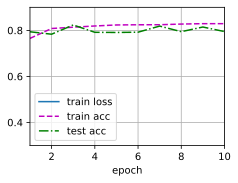

In [17]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)